Loading validation dataset...
Rounding threshold column to 1 decimal place...
Validation data shape (after rounding): (202, 18)

Applying linear interpolation baseline model to validation data...
\Baseline Model MAE on Validation Set: 0.0859

Plotting results for model_id: 5


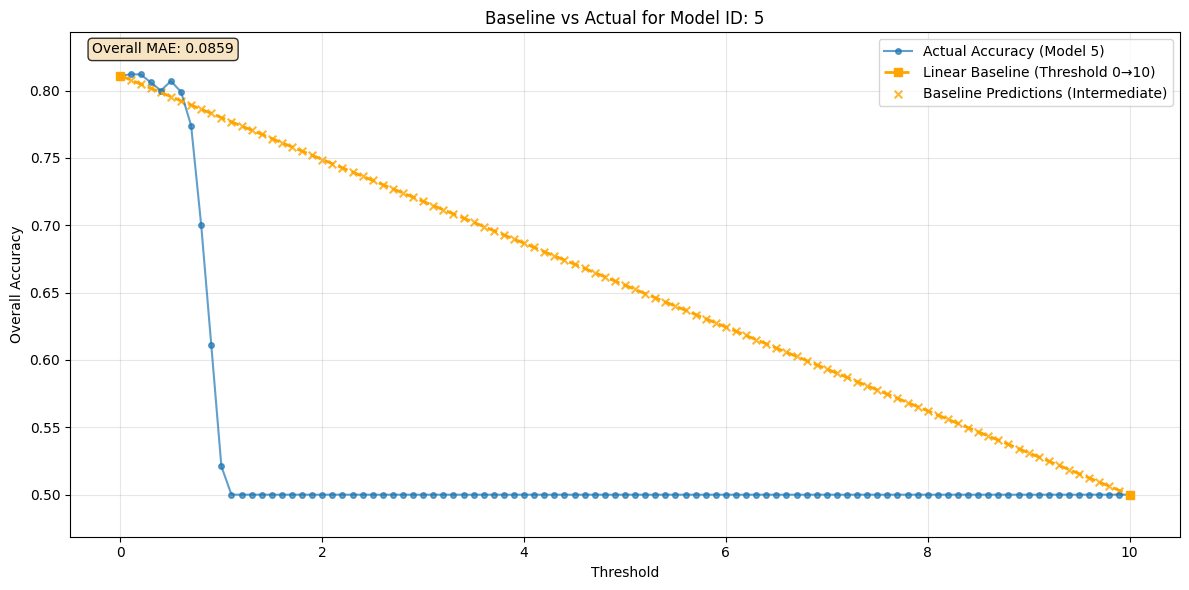

For model 5:
  Accuracy at threshold 0: 0.8110
  Accuracy at threshold 10: 0.5000
  Linear slope: -0.031100 per threshold unit
  Number of intermediate predictions: 99

Summary:
Total predictions made: 198
Models processed: 2
Linear Interpolation Baseline MAE: 0.0859


In [5]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# --- Configuration ---
DATASET_PATH = Path("data_split") # Path to the folder with pre-split CSVs
INTERMEDIATE_THRESHOLDS = np.round(np.arange(0.1, 10.0, 0.1), 1) # 99 points
TARGET_COL = 'overall_accuracy'
PARAMS_REDUCTION_COL = 'params_reduction_pct'

# --- 1. Load Validation Dataset ---
print("Loading validation dataset...")
try:
    validation_df_raw = pd.read_csv(DATASET_PATH / "validation_dataset.csv")
except FileNotFoundError as e:
    print(f"Error: Dataset file not found. Make sure '{e.filename}' exists.")
    print(f"Please run the `prepare_datasets.py` script first to generate '{DATASET_PATH / 'validation_dataset.csv'}'.")
    exit()

# Round the threshold column to fix precision issues (good practice)
print("Rounding threshold column to 1 decimal place...")
validation_df = validation_df_raw.copy()
validation_df['threshold'] = validation_df['threshold'].round(1)

print(f"Validation data shape (after rounding): {validation_df.shape}")

# --- 2. Implement Linear Interpolation Baseline Model ---
print("\nApplying linear interpolation baseline model to validation data...")
baseline_predictions_all = []
actual_accuracies_all = []
model_ids_for_plot = [] # To select one for plotting
acc0_for_plot = {}
acc10_for_plot = {}

for model_id, group in validation_df.groupby('model_id'):
    group = group.sort_values(by='threshold').reset_index(drop=True)

    # Get accuracy at threshold 0.0 and 10.0
    acc_at_0_series = group[group['threshold'] == 0.0][TARGET_COL]
    acc_at_10_series = group[group['threshold'] == 10.0][TARGET_COL]

    if acc_at_0_series.empty or acc_at_10_series.empty:
        print(f"Warning: Skipping model_id {model_id} due to missing acc_0 or acc_10 data.")
        continue
    
    acc_0_val = acc_at_0_series.iloc[0]
    acc_10_val = acc_at_10_series.iloc[0]
    
    # Store for plotting
    if model_id not in acc0_for_plot: # Store only once
        model_ids_for_plot.append(model_id)
        acc0_for_plot[model_id] = acc_0_val
        acc10_for_plot[model_id] = acc_10_val

    # Get intermediate data points
    intermediate_data = group[group['threshold'].isin(INTERMEDIATE_THRESHOLDS)].copy()
    if intermediate_data.empty:
        print(f"Warning: model_id {model_id} has no intermediate points. Skipping.")
        continue

    # Ensure order is correct for sequence
    intermediate_data = intermediate_data.sort_values(by='threshold')
    
    # Get thresholds for intermediate points
    intermediate_thresholds = intermediate_data['threshold'].values
    
    # Linear interpolation between acc_0 (at threshold 0) and acc_10 (at threshold 10)
    # Formula: y = y0 + (y1 - y0) * (x - x0) / (x1 - x0)
    # Where: x0=0, y0=acc_0, x1=10, y1=acc_10, x=intermediate_threshold
    predicted_accuracies_intermediate = acc_0_val + (acc_10_val - acc_0_val) * (intermediate_thresholds - 0) / (10 - 0)
    
    # Clip predictions to be within [0, 1] (though linear interpolation should naturally stay in bounds)
    predicted_accuracies_intermediate = np.clip(predicted_accuracies_intermediate, 0, 1)
    
    # Get actual accuracies for intermediate thresholds
    actual_accuracies_intermediate = intermediate_data[TARGET_COL].values

    # Store predictions and actuals
    baseline_predictions_all.extend(predicted_accuracies_intermediate)
    actual_accuracies_all.extend(actual_accuracies_intermediate)

if not baseline_predictions_all:
    print("Error: No baseline predictions could be made. Check validation data and logic.")
    exit()

# --- 3. Calculate MAE on the Validation Set ---
baseline_mae = mean_absolute_error(actual_accuracies_all, baseline_predictions_all)
print(f"\Baseline Model MAE on Validation Set: {baseline_mae:.4f}")

# --- 4. Plot example chart ---
if model_ids_for_plot:
    plot_model_id = model_ids_for_plot[0] # Plot the first model processed
    print(f"\nPlotting results for model_id: {plot_model_id}")

    model_group_for_plot = validation_df[validation_df['model_id'] == plot_model_id].sort_values(by='threshold')
    
    # Get all data points for this model (including 0 and 10)
    all_thresholds_plot = model_group_for_plot['threshold'].values
    all_actual_accuracies_plot = model_group_for_plot[TARGET_COL].values
    
    # Get intermediate data for this model
    actual_intermediate_df = model_group_for_plot[model_group_for_plot['threshold'].isin(INTERMEDIATE_THRESHOLDS)]
    intermediate_thresholds_plot = actual_intermediate_df['threshold'].values
    intermediate_actual_accuracies_plot = actual_intermediate_df[TARGET_COL].values

    # Generate baseline predictions for intermediate points
    current_acc0 = acc0_for_plot[plot_model_id]
    current_acc10 = acc10_for_plot[plot_model_id]
    baseline_predictions_plot = current_acc0 + (current_acc10 - current_acc0) * (intermediate_thresholds_plot - 0) / (10 - 0)
    baseline_predictions_plot = np.clip(baseline_predictions_plot, 0, 1)

    # Create arrays for the full baseline line (from 0 to 10)
    full_baseline_thresholds = np.array([0.0, 10.0])
    full_baseline_accuracies = np.array([current_acc0, current_acc10])

    plt.figure(figsize=(12, 6))
    
    # Plot all actual data points
    plt.plot(all_thresholds_plot, all_actual_accuracies_plot, 
             label=f'Actual Accuracy (Model {plot_model_id})', 
             marker='o', linestyle='-', alpha=0.7, markersize=4)
    
    # Plot the straight baseline line from 0 to 10
    plt.plot(full_baseline_thresholds, full_baseline_accuracies, 
             label=f'Linear Baseline (Threshold 0→10)', 
             marker='s', linestyle='--', linewidth=2, markersize=6, color='orange')
    
    # Highlight the intermediate prediction points
    plt.scatter(intermediate_thresholds_plot, baseline_predictions_plot, 
                label=f'Baseline Predictions (Intermediate)', 
                marker='x', s=30, color='orange', alpha=0.8)

    plt.title(f"Baseline vs Actual for Model ID: {plot_model_id}")
    plt.xlabel("Threshold")
    plt.ylabel("Overall Accuracy")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Dynamic Y-axis limits
    all_plot_values = np.concatenate([all_actual_accuracies_plot, [current_acc0, current_acc10]])
    min_val_plot = np.nanmin(all_plot_values)
    max_val_plot = np.nanmax(all_plot_values)
    margin = (max_val_plot - min_val_plot) * 0.1
    plt.ylim(max(0, min_val_plot - margin), min(1, max_val_plot + margin))
    
    # Add text annotation with MAE
    plt.text(0.02, 0.98, f'Overall MAE: {baseline_mae:.4f}', 
             transform=plt.gca().transAxes, 
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    print(f"For model {plot_model_id}:")
    print(f"  Accuracy at threshold 0: {current_acc0:.4f}")
    print(f"  Accuracy at threshold 10: {current_acc10:.4f}")
    print(f"  Linear slope: {(current_acc10 - current_acc0) / 10:.6f} per threshold unit")
    print(f"  Number of intermediate predictions: {len(baseline_predictions_plot)}")
    
else:
    print("No models were suitable for plotting.")

print(f"\nSummary:")
print(f"Total predictions made: {len(baseline_predictions_all)}")
print(f"Models processed: {len(model_ids_for_plot)}")
print(f"Linear Interpolation Baseline MAE: {baseline_mae:.4f}")